In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBRegressor
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training Time: 5.31 seconds


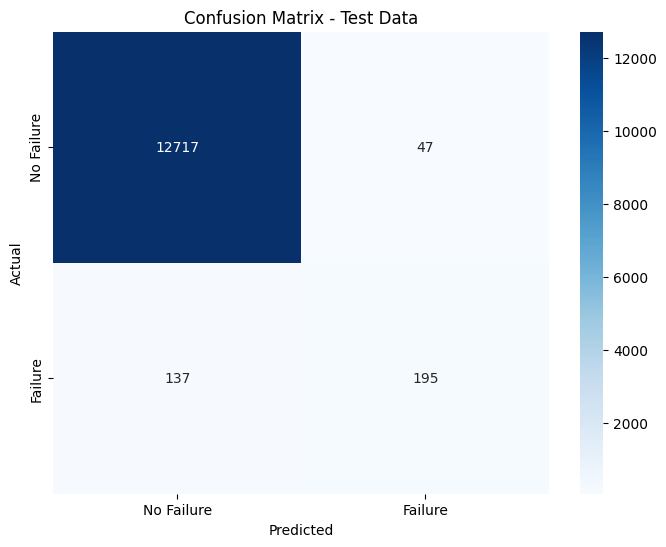

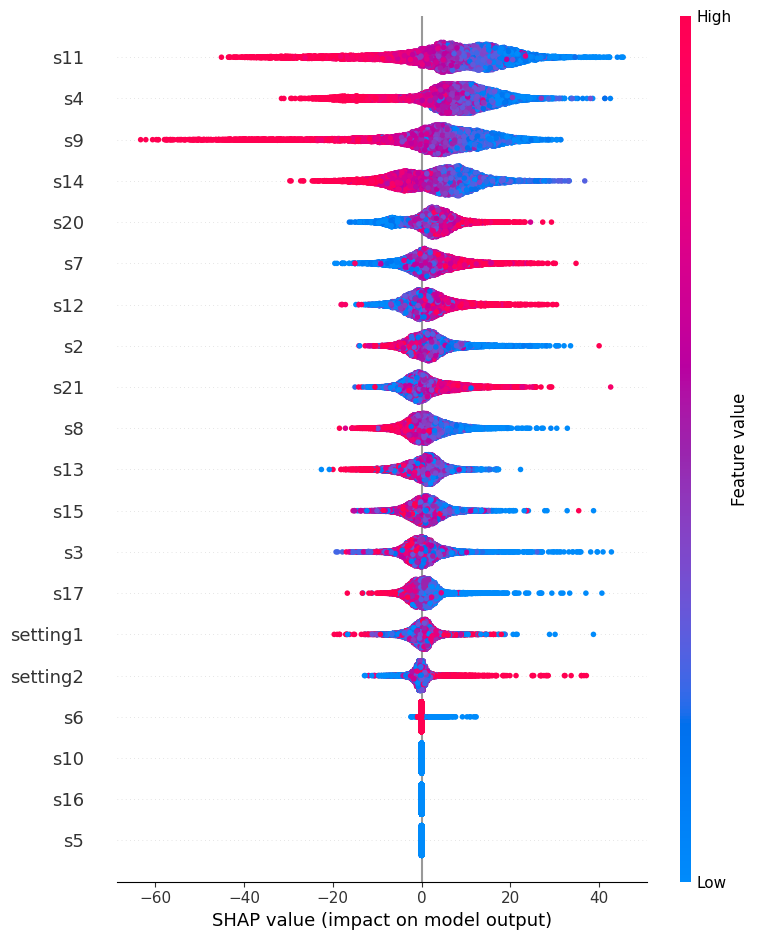

Model saved in JSON format to xgb_model.json


In [8]:


# Set seed for reproducibility
np.random.seed(1234)

# Data Loading and Preprocessing
train_df = pd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_train.txt', sep=" ", header=None).dropna(axis=1)
test_df = pd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_test.txt', sep=" ", header=None).dropna(axis=1)
truth_df = pd.read_csv('/content/drive/MyDrive/INTEL_AI/PM_truth.txt', sep=" ", header=None).dropna(axis=1)

# Assign column names
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]
train_df.columns = cols_names
test_df.columns = cols_names
truth_df.columns = ['additional_rul']

# Add Remaining Useful Life (RUL) for training data
train_df['RUL'] = train_df.groupby('id')['cycle'].transform('max') - train_df['cycle']

# Add RUL for test data using truth_df
truth_df['id'] = truth_df.index + 1
rul = test_df.groupby('id')['cycle'].max().reset_index()
rul.columns = ['id', 'max_cycle']
truth_df = truth_df.merge(rul, on='id', how='left')
truth_df['RUL'] = truth_df['max_cycle'] + truth_df['additional_rul']
test_df = test_df.merge(truth_df[['id', 'RUL']], on='id', how='left')
test_df['RUL'] = test_df['RUL'] - test_df['cycle']

# Normalize sensor data
features = [col for col in cols_names if col not in ['id', 'cycle', 'RUL']]
scaler = StandardScaler()
train_df[features] = scaler.fit_transform(train_df[features])
test_df[features] = scaler.transform(test_df[features])

# Prepare data for model training and testing
X = train_df[features].values
y = train_df['RUL'].values
X_test = test_df[features].values
y_test = test_df['RUL'].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, max_depth=6)
train_start = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - train_start
print(f"Training Time: {train_time:.2f} seconds")

# Make predictions
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Define a threshold for binary classification (e.g., w1 = 30 cycles)
w1 = 30
y_val_binary = (y_val <= w1).astype(int)
y_val_pred_binary = (y_val_pred <= w1).astype(int)
y_test_binary = (y_test <= w1).astype(int)
y_test_pred_binary = (y_test_pred <= w1).astype(int)

# Calculate and plot Confusion Matrix for Test Data
test_confusion_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SHAP Feature Importance
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)


# Save the trained XGBoost model as JSON
model_json_path = "xgb_model.json"
xgb_model.get_booster().save_model(model_json_path)
print(f"Model saved in JSON format to {model_json_path}")
